# ACH Fraud Detection Simulator – Analysis Notebook

This notebook explores the synthetic ACH dataset generated for my ACH Fraud Detection Simulator project.

Goals:

- Understand overall ACH behavior in the synthetic data.
- Explore return codes and how they relate to funding speed and account age.
- See how the simple rule based risk scoring behaves.
- Compare rule based alerts to the synthetic fraud labels in the data.
- Practice walking through a clear, interview friendly story from data to findings.


In [1]:
import pandas as pd
import matplotlib.pyplot as plt

# Display more columns by default
pd.set_option("display.max_columns", 50)

# Load the scored transactions created by run_scoring.py
df = pd.read_csv("../data/ach_transactions_scored.csv")

df.head()


Matplotlib is building the font cache; this may take a moment.


,transaction_id,user_id,timestamp_utc,direction,amount_usd,ach_type,funding_speed,device_id,ip_country,return_code,returned,days_to_return,fraud_pattern_type,is_fraud_pattern,account_age_days,risk_score
0,txn_1,user_487,2025-01-07T19:46:00,debit,1302.56,PULL,standard,device_195,BR,NaN,False,NaN,NaN,False,121,1
1,txn_2,user_362,2025-02-14T18:15:00,debit,895.71,PUSH,standard,device_277,US,NaN,False,NaN,NaN,False,325,1
2,txn_3,user_25,2025-02-04T15:28:00,debit,182.08,PULL,standard,device_46,BR,NaN,False,NaN,NaN,False,285,1
3,txn_4,user_448,2025-01-04T04:52:00,debit,483.81,PUSH,instant,device_161,US,NaN,False,NaN,NaN,False,348,1
4,txn_5,user_373,2025-02-08T13:17:00,debit,630.23,PULL,standard,device_171,BR,R01,True,3.0,NaN,False,149,2


In [2]:
# Number of rows and columns
df.shape


(5000, 16)

In [3]:
# Column names and data types
df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 16 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   transaction_id      5000 non-null   object 
 1   user_id             5000 non-null   object 
 2   timestamp_utc       5000 non-null   object 
 3   direction           5000 non-null   object 
 4   amount_usd          5000 non-null   float64
 5   ach_type            5000 non-null   object 
 6   funding_speed       5000 non-null   object 
 7   device_id           5000 non-null   object 
 8   ip_country          5000 non-null   object 
 9   return_code         620 non-null    object 
 10  returned            5000 non-null   bool   
 11  days_to_return      620 non-null    float64
 12  fraud_pattern_type  162 non-null    object 
 13  is_fraud_pattern    5000 non-null   bool   
 14  account_age_days    5000 non-null   int64  
 15  risk_score          5000 non-null   int64  
dtypes: boo

In [8]:
df.info()

df.describe()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 16 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   transaction_id      5000 non-null   object 
 1   user_id             5000 non-null   object 
 2   timestamp_utc       5000 non-null   object 
 3   direction           5000 non-null   object 
 4   amount_usd          5000 non-null   float64
 5   ach_type            5000 non-null   object 
 6   funding_speed       5000 non-null   object 
 7   device_id           5000 non-null   object 
 8   ip_country          5000 non-null   object 
 9   return_code         620 non-null    object 
 10  returned            5000 non-null   bool   
 11  days_to_return      620 non-null    float64
 12  fraud_pattern_type  162 non-null    object 
 13  is_fraud_pattern    5000 non-null   bool   
 14  account_age_days    5000 non-null   int64  
 15  risk_score          5000 non-null   int64  
dtypes: boo

,amount_usd,days_to_return,account_age_days,risk_score
count,5000.000000,620.000000,5000.000000,5000.000000
mean,756.626540,12.246774,182.407000,1.028600
std,424.223533,8.316366,105.577815,0.174895
min,10.230000,1.000000,1.000000,1.000000
25%,399.887500,5.000000,95.000000,1.000000
50%,756.575000,10.000000,179.000000,1.000000
75%,1124.052500,19.000000,276.000000,1.000000
max,1499.940000,29.000000,364.000000,3.000000


In [9]:
# Overall return rate
overall_return_rate = df["returned"].mean()
print(f"Overall return rate: {overall_return_rate:.2%}")


Overall return rate: 12.40%


In [10]:
# Return code counts, including missing (no return)
df["return_code"].value_counts(dropna=False)


return_code
NaN    4380
R01     131
R02     125
R10     123
R03     120
R29      94
R51      27
Name: count, dtype: int64

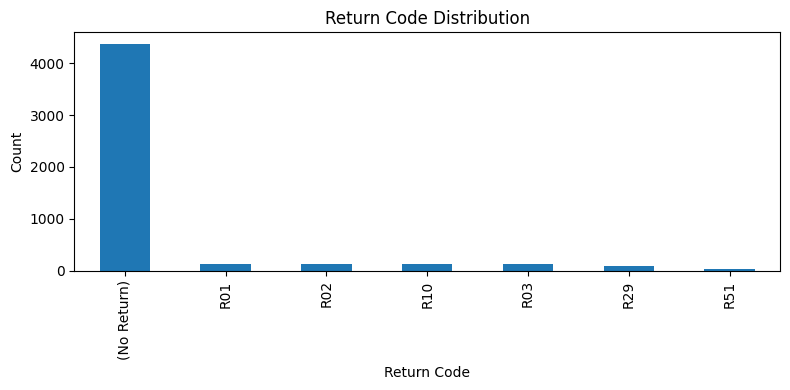

In [11]:
return_counts = df["return_code"].fillna("(No Return)").value_counts()

plt.figure(figsize=(8, 4))
return_counts.plot(kind="bar")
plt.title("Return Code Distribution")
plt.xlabel("Return Code")
plt.ylabel("Count")
plt.tight_layout()
plt.show()


In [12]:
high_risk_codes = ["R01", "R10", "R29"]

# Subsets by funding speed
instant = df[df["funding_speed"] == "instant"]
standard = df[df["funding_speed"] == "standard"]

instant_high_risk_rate = instant["return_code"].isin(high_risk_codes).mean()
standard_high_risk_rate = standard["return_code"].isin(high_risk_codes).mean()

print(f"High risk return rate (instant):  {instant_high_risk_rate:.2%}")
print(f"High risk return rate (standard): {standard_high_risk_rate:.2%}")


High risk return rate (instant):  6.75%
High risk return rate (standard): 7.01%


### High risk return codes by funding speed

Here I compare the rate of high risk return codes (R01, R10, R29) for instant versus standard funding.

In a real environment, I would want to see whether instant funding amplifies loss risk, especially for new users and higher amounts. The synthetic data is set up to reflect that pattern, so I expect to see a higher high risk return rate for instant ACH compared to standard ACH.


In [14]:
# Distribution of risk_score in the dataset
risk_score_counts = df["risk_score"].value_counts().sort_index()
risk_score_counts


risk_score
1    4864
2     129
3       7
Name: count, dtype: int64

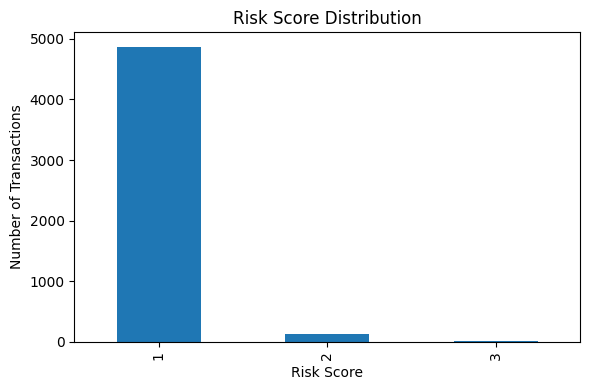

In [15]:
plt.figure(figsize=(6, 4))
risk_score_counts.plot(kind="bar")
plt.title("Risk Score Distribution")
plt.xlabel("Risk Score")
plt.ylabel("Number of Transactions")
plt.tight_layout()
plt.show()


In [16]:
# Aggregate total risk score by user
user_risk = (
    df.groupby("user_id")["risk_score"]
    .sum()
    .reset_index()
    .sort_values("risk_score", ascending=False)
    .head(10)
)

user_risk


,user_id,risk_score
108,user_197,20
385,user_446,20
199,user_279,20
43,user_138,19
145,user_23,19
250,user_324,18
227,user_303,18
379,user_440,18
412,user_470,18
463,user_66,18


In [17]:
# Device usage: how many unique users per device
device_user_counts = (
    df.groupby("device_id")["user_id"]
    .nunique()
    .reset_index()
    .rename(columns={"user_id": "unique_users"})
    .sort_values("unique_users", ascending=False)
)

# Show the most shared devices
device_user_counts.head(10)


,device_id,unique_users
150,device_234,28
191,device_271,27
100,device_19,26
149,device_233,25
97,device_187,25
246,device_51,24
66,device_159,24
232,device_39,24
228,device_35,24
192,device_272,24


In [18]:
suspicious_devices = device_user_counts[device_user_counts["unique_users"] >= 5]
suspicious_devices.head(10)


,device_id,unique_users
150,device_234,28
191,device_271,27
100,device_19,26
149,device_233,25
97,device_187,25
246,device_51,24
66,device_159,24
232,device_39,24
228,device_35,24
192,device_272,24


In [19]:
df["is_fraud_pattern"].value_counts()


is_fraud_pattern
False    4838
True      162
Name: count, dtype: int64

In [20]:
# Define high risk prediction based on risk_score threshold
df["predicted_high_risk"] = df["risk_score"] >= 2

# True positives
tp = ((df["predicted_high_risk"] == True) & (df["is_fraud_pattern"] == True)).sum()

# False positives
fp = ((df["predicted_high_risk"] == True) & (df["is_fraud_pattern"] == False)).sum()

# False negatives
fn = ((df["predicted_high_risk"] == False) & (df["is_fraud_pattern"] == True)).sum()

precision = tp / (tp + fp) if (tp + fp) > 0 else 0
recall = tp / (tp + fn) if (tp + fn) > 0 else 0

print(f"True positives:  {tp}")
print(f"False positives: {fp}")
print(f"False negatives: {fn}")
print(f"Precision:       {precision:.2%}")
print(f"Recall:          {recall:.2%}")


True positives:  61
False positives: 75
False negatives: 101
Precision:       44.85%
Recall:          37.65%


### Rule performance against synthetic fraud labels

The data includes a synthetic `is_fraud_pattern` label that marks transactions associated with injected fraud behaviors such as instant ACH abuse, first party fraud, and synthetic identity.

I define a simple rule based classifier where any transaction with `risk_score >= 2` is treated as high risk. Then I compare that to the `is_fraud_pattern` label to calculate:

- True positives, fraud pattern rows correctly flagged as high risk.
- False positives, legitimate rows flagged as high risk.
- False negatives, fraud pattern rows that were not flagged.

From these I compute:

- **Precision**, among transactions I flag as high risk, how many are truly fraud patterns.
- **Recall**, among all fraud patterns in the data, how many I successfully catch.

In a real environment, I would tune the rules, thresholds, and possibly add models to find a better balance between precision and recall, depending on operational costs and risk appetite.


## Summary and talking points for interviews

This project is designed to mirror the type of work a payments risk analyst might do.

Key points:

- I generated synthetic ACH data with realistic attributes such as amount, funding speed, account age, device, and return codes, and I injected specific fraud patterns such as instant ACH abuse, first party fraud, and synthetic identity behavior.
- I built a small rule based risk engine that scores transactions based on these patterns and flags high risk activity.
- I analyzed the data to understand return behavior, risk score distribution, and concentration of risk in certain users and devices.
- I compared the rule based risk scores to the synthetic `is_fraud_pattern` labels to get a first pass view of precision and recall.
- I built a Streamlit dashboard to make this analysis easier to explore and to mimic internal tooling that a risk team might use day to day.

How I would present this in an interview:

- Start with the business problem, managing ACH risk and understanding how instant funding and returns create exposure.
- Explain the synthetic dataset and the fraud patterns I decided to model.
- Walk through the rules I implemented and why they make sense operationally.
- Show how I evaluate the rules with simple metrics like precision and recall.
- Close with how I would extend this work, for example by adding more features, tuning thresholds, or introducing a model to complement the rules.

The goal of this notebook is not to be perfect statistically. The goal is to practice thinking like a risk analyst, to build and explain a complete workflow, and to have something concrete I can reference when talking through my approach in an interview.
